In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [3]:
# for gpu purposes:

torch.cuda.is_available()

True

In [4]:
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

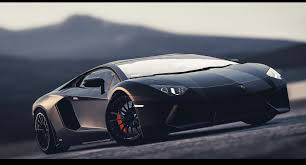

In [5]:
# checking is our folder working or not:

with Image.open('../PYTORCH_NOTEBOOKS/Data/CarBrand/Test/lamborghini/23.jpg') as im:
    display(im)

In [6]:
path = "../PYTORCH_NOTEBOOKS/Data/CarBrand/"
img_names = []

for folder,subfolders,filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)

In [7]:
len(img_names)

122

In [8]:
img_sizes = []
rejected = []
for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)

In [9]:
print(len(img_sizes),'\n',len(rejected))

122 
 0


In [10]:
df = pd.DataFrame(img_sizes)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       122 non-null    int64
 1   1       122 non-null    int64
dtypes: int64(2)
memory usage: 2.0 KB


## Finding the pixel size for our model:

In [12]:
lamborghini = Image.open('../PYTORCH_NOTEBOOKS/Data/CarBrand/Train/lamborghini/18.jpg')

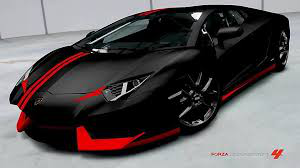

In [13]:
display(lamborghini)

In [14]:
lamborghini.size

(300, 168)

In [15]:
lamborghini.getpixel((0,0))

(183, 184, 189)

## getting the pixel size using transform method:

In [16]:
transform = transforms.Compose([transforms.ToTensor()])

im = transform(lamborghini)
print(type(im))
print(im.shape)

<class 'torch.Tensor'>
torch.Size([3, 168, 300])


#### Making the image into specific image size Tensor(we make this (168,300) pixel image into a (224,224) pixel image tensor):

In [17]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [18]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

## Training data and Testing data Preparation:

In [19]:
root = '../PYTORCH_NOTEBOOKS/Data/CarBrand'

train_data = datasets.ImageFolder(os.path.join(root,'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test'), transform=test_transform)

In [20]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)

In [21]:
# checking the class of folder image:

class_names = train_data.classes

In [22]:
class_names

['audi', 'lamborghini', 'mercedes']

In [23]:
len(train_data)

64

In [24]:
len(test_data)

58

In [25]:
# getting the first batch of image:

for images,labels in train_loader:
    break

In [26]:
images.shape

torch.Size([10, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


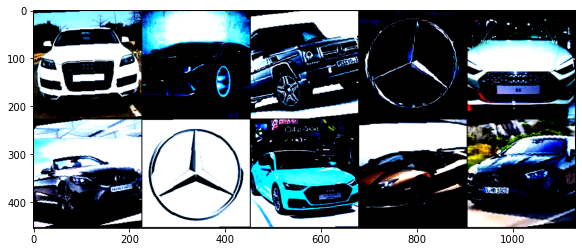

In [27]:
# using make grid we can convert any pixel values into image for viewing:
im = make_grid(images,nrow=5)
inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std = [1/0.229, 1/0.224, 1/0.225])

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))  

# Model Making:

In [28]:
class CNNcarbrand(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(16*54*54,120)  # ---> (((224-2)/2)-2)/2 {{convulution layer loose some pixel and using max pooling the pixel size became very less}}
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,3)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,16*54*54) # -----> flatten out the data
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x,dim=1)

In [29]:
torch.manual_seed(101)
model = CNNcarbrand().cuda()

In [30]:
next(model.parameters()).is_cuda

True

In [31]:
for param in model.parameters():
    print(param.numel())

162
6
864
16
5598720
120
10080
84
252
3


In [32]:
model.parameters

<bound method Module.parameters of CNNcarbrand(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)>

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training and Testing the Model

In [34]:
import time
start_time = time.time()


epochs = 8
max_trn_batch = 300
max_tst_batch = 50

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        
        if b == max_trn_batch:
            break
        b += 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted==y_train).sum()
        train_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%2 == 0:
            accuracy = train_corr.item()/b
            print(f"epoch {i} loss: {loss.item()} accuray: {accuracy}")
            
    train_losses.append(loss)
    train_correct.append(train_corr)
    
    #TEST
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):
            X_test = X_test.cuda()
            y_test = y_test.cuda()
           
            if b == max_tst_batch:
                break
                
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted==y_test).sum()
            test_corr = test_corr + batch_corr
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)
    
total_time = time.time() - start_time
print(f'total_time: {total_time} sec')

epoch 0 loss: 1.0699831247329712 accuray: 3.5
epoch 0 loss: 2.441498279571533 accuray: 3.25
epoch 0 loss: 1.063921570777893 accuray: 3.1666666666666665
epoch 1 loss: 1.2849271297454834 accuray: 3.0
epoch 1 loss: 0.8482505679130554 accuray: 4.5
epoch 1 loss: 1.0006375312805176 accuray: 4.5
epoch 2 loss: 0.7880879044532776 accuray: 5.5
epoch 2 loss: 0.8360050320625305 accuray: 6.25
epoch 2 loss: 0.8592389225959778 accuray: 6.333333333333333
epoch 3 loss: 0.945052981376648 accuray: 4.5
epoch 3 loss: 0.49363842606544495 accuray: 6.25
epoch 3 loss: 0.6739341020584106 accuray: 6.666666666666667
epoch 4 loss: 0.7569559812545776 accuray: 8.0
epoch 4 loss: 0.9370503425598145 accuray: 7.25
epoch 4 loss: 0.33655065298080444 accuray: 7.833333333333333
epoch 5 loss: 0.593854546546936 accuray: 5.0
epoch 5 loss: 0.33166638016700745 accuray: 6.75
epoch 5 loss: 0.579254686832428 accuray: 7.0
epoch 6 loss: 0.41329383850097656 accuray: 7.5
epoch 6 loss: 0.3553439974784851 accuray: 8.5
epoch 6 loss: 0.401

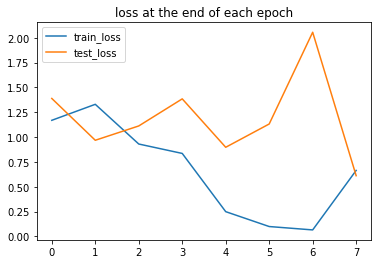

In [35]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.title('loss at the end of each epoch')
plt.legend()

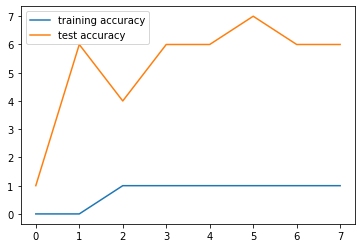

In [36]:
plt.plot([t/30 for t in train_correct], label='training accuracy')
plt.plot([t/5 for t in test_correct], label = 'test accuracy')
plt.legend()

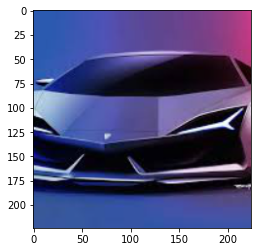

In [37]:
image_index = 15
im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [38]:
model.eval()

with torch.no_grad():
    new_pred = model(test_data[image_index][0].view(1,3,224,224).cuda()).argmax()
    
class_names[new_pred]

'lamborghini'

In [39]:
# checking the testing data with train data:

check_data = Image.open('../PYTORCH_NOTEBOOKS/Data/CarBrand/Train/lamborghini/15.jpg')

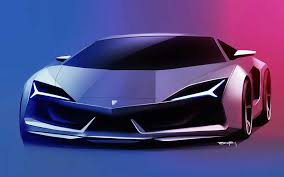

In [40]:
display(check_data)